# Self Driving Car 

In [1]:
# Credits: https://github.com/SullyChen/Autopilot-TensorFlow
# Research paper: End to End Learning for Self-Driving Cars by Nvidia. [https://arxiv.org/pdf/1604.07316.pdf]

# NVidia dataset: 72 hrs of video => 72*60*60*30 = 7,776,000 images
# Nvidia blog: https://devblogs.nvidia.com/deep-learning-self-driving-cars/


# Our Dataset: https://github.com/SullyChen/Autopilot-TensorFlow [https://drive.google.com/file/d/0B-KJCaaF7elleG1RbzVPZWV4Tlk/view]
# Size: 25 minutes = 25*60*30 = 45,000 images ~ 2.3 GB


# If you want to try on a slightly large dataset: 70 minutes of data ~ 223GB
# Refer: https://medium.com/udacity/open-sourcing-223gb-of-mountain-view-driving-data-f6b5593fbfa5
# Format: Image, latitude, longitude, gear, brake, throttle, steering angles and speed



# Additional Installations:
# pip3 install h5py


# AWS: https://aws.amazon.com/blogs/machine-learning/get-started-with-deep-learning-using-the-aws-deep-learning-ami/

# Youtube:https://www.youtube.com/watch?v=qhUvQiKec2U
# Further reading and extensions: https://medium.com/udacity/teaching-a-machine-to-steer-a-car-d73217f2492c
# More data: https://medium.com/udacity/open-sourcing-223gb-of-mountain-view-driving-data-f6b5593fbfa5

In [8]:
# read images and steering angles from driving_dataset folder

from __future__ import division

import os
import numpy as np
import random

from scipy import pi
from itertools import islice



DATA_FOLDER = './driving_dataset/' # change this to your folder
TRAIN_FILE = os.path.join(DATA_FOLDER, 'data.txt')


split =0.7
X = []
y = []
with open(TRAIN_FILE) as fp:
    for line in islice(fp, 45406):
        path, angle = line.strip().split()
        full_path = os.path.join(DATA_FOLDER, path)
        X.append(full_path)
        
        # converting angle from degrees to radians
        y.append(float(angle) * pi / 180 )


y = np.array(y)
print("Completed processing data.txt")

split_index = int(len(y)*0.7)

train_y = y[:split_index]
test_y = y[split_index:]

          

Completed processing data.txt


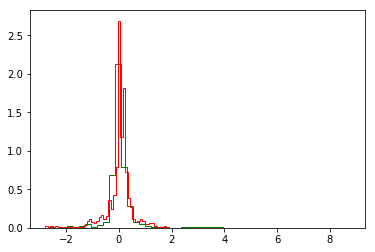

In [9]:
import numpy;

# PDF of train and test 'y' values. 
import matplotlib.pyplot as plt 
plt.hist(train_y, bins=50, normed=1, color='green', histtype ='step');
plt.hist(test_y, bins=50, normed=1, color='red', histtype ='step');
plt.show()




In [10]:
#Model 0: Base line Model: y_test_pred = mean(y_train_i) 
train_mean_y = np.mean(train_y)

print('Test_MSE(MEAN):%f' % np.mean(np.square(test_y-train_mean_y)) )

print('Test_MSE(ZERO):%f' % np.mean(np.square(test_y-0.0)) )


Test_MSE(MEAN):0.241561
Test_MSE(ZERO):0.241107


## Loading and Transforming Data

In [ ]:
import scipy.misc
import random

xs = []
ys = []

#points to the end of the last batch
train_batch_pointer = 0
val_batch_pointer = 0

#read data.txt
with open("driving_dataset/data.txt") as f:
    for line in f:
        xs.append("driving_dataset/" + line.split()[0])
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        ys.append(float(line.split()[1]) * scipy.pi / 180)

#get number of images
num_images = len(xs)


train_xs = xs[:int(len(xs) * 0.7)]
train_ys = ys[:int(len(xs) * 0.7)]

val_xs = xs[-int(len(xs) * 0.3):]
val_ys = ys[-int(len(xs) * 0.3):]

num_train_images = len(train_xs)
num_val_images = len(val_xs)

In [ ]:
def LoadTrainBatch(batch_size):
    global train_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(scipy.misc.imresize(scipy.misc.imread(train_xs[(train_batch_pointer + i) % \
                                                                    num_train_images])[-150:],[66, 200]) /255.0)
        y_out.append([train_ys[(train_batch_pointer + i) % num_train_images]])
    train_batch_pointer += batch_size
    return x_out, y_out

def LoadValBatch(batch_size):
    global val_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(scipy.misc.imresize(scipy.misc.imread(val_xs[(val_batch_pointer + i) % \
                                                                  num_val_images])[-150:], [66, 200]) / 255.0)
        y_out.append([val_ys[(val_batch_pointer + i) % num_val_images]])
    val_batch_pointer += batch_size
    return x_out, y_out

## Defining CNN model

In [ ]:
import tensorflow as tf
import scipy

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W, stride):
  return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='VALID')

x = tf.placeholder(tf.float32, shape=[None, 66, 200, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 1])

x_image = x


In [ ]:
#first convolutional layer
W_conv1 = weight_variable([5, 5, 3, 24])
b_conv1 = bias_variable([24])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, 2) + b_conv1)

#second convolutional layer
W_conv2 = weight_variable([5, 5, 24, 36])
b_conv2 = bias_variable([36])

h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2, 2) + b_conv2)

#third convolutional layer
W_conv3 = weight_variable([5, 5, 36, 48])
b_conv3 = bias_variable([48])

h_conv3 = tf.nn.relu(conv2d(h_conv2, W_conv3, 2) + b_conv3)

#fourth convolutional layer
W_conv4 = weight_variable([3, 3, 48, 64])
b_conv4 = bias_variable([64])

h_conv4 = tf.nn.relu(conv2d(h_conv3, W_conv4, 1) + b_conv4)

#fifth convolutional layer
W_conv5 = weight_variable([3, 3, 64, 64])
b_conv5 = bias_variable([64])

h_conv5 = tf.nn.relu(conv2d(h_conv4, W_conv5, 1) + b_conv5)

#FCL 1
W_fc1 = weight_variable([1152, 1164])
b_fc1 = bias_variable([1164])

h_conv5_flat = tf.reshape(h_conv5, [-1, 1152])
h_fc1 = tf.nn.relu(tf.matmul(h_conv5_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#FCL 2
W_fc2 = weight_variable([1164, 100])
b_fc2 = bias_variable([100])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

#FCL 3
W_fc3 = weight_variable([100, 50])
b_fc3 = bias_variable([50])

h_fc3 = tf.nn.relu(tf.matmul(h_fc2_drop, W_fc3) + b_fc3)

h_fc3_drop = tf.nn.dropout(h_fc3, keep_prob)

#FCL 3
W_fc4 = weight_variable([50, 10])
b_fc4 = bias_variable([10])

h_fc4 = tf.nn.relu(tf.matmul(h_fc3_drop, W_fc4) + b_fc4)

h_fc4_drop = tf.nn.dropout(h_fc4, keep_prob)

In [ ]:
#Output
W_fc5 = weight_variable([10, 1])
b_fc5 = bias_variable([1])

y =tf.matmul(h_fc4_drop, W_fc5) + b_fc5

## Compiling and Training

In [ ]:
import os
import tensorflow as tf
from tensorflow.core.protobuf import saver_pb2
import driving_data
import model

LOGDIR = './save'

sess = tf.InteractiveSession()

L2NormConst = 0.001

train_vars = tf.trainable_variables()

loss = tf.reduce_mean(tf.square(tf.subtract(model.y_, model.y))) + \
tf.add_n([tf.nn.l2_loss(v) for v in train_vars]) * L2NormConst

train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)
sess.run(tf.initialize_all_variables())

# create a summary to monitor cost tensor
tf.summary.scalar("loss", loss)
# merge all summaries into a single op
merged_summary_op =  tf.summary.merge_all()

saver = tf.train.Saver(write_version = saver_pb2.SaverDef.V1)

# op to write logs to Tensorboard
logs_path = './logs'
summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

epochs = 30
batch_size = 100

In [ ]:
# train over the dataset about 30 times
for epoch in range(epochs):
  for i in range(int(driving_data.num_images/batch_size)):
    xs, ys = driving_data.LoadTrainBatch(batch_size)
    train_step.run(feed_dict={model.x: xs, model.y_: ys, model.keep_prob: 0.5})
    if i % 10 == 0:
      xs, ys = driving_data.LoadValBatch(batch_size)
      loss_value = loss.eval(feed_dict={model.x:xs, model.y_: ys, model.keep_prob: 1.0})
      print("Epoch: %d, Step: %d, Loss: %g" % (epoch, epoch * batch_size + i, loss_value))

    # write logs at every iteration
    summary = merged_summary_op.eval(feed_dict={model.x:xs, model.y_: ys, model.keep_prob: 1.0})
    summary_writer.add_summary(summary, epoch * driving_data.num_images/batch_size + i)

    if i % batch_size == 0:
      if not os.path.exists(LOGDIR):
        os.makedirs(LOGDIR)
      checkpoint_path = os.path.join(LOGDIR, "model.ckpt")
      filename = saver.save(sess, checkpoint_path)
  print("Model saved in file: %s" % filename)

print("Run the command line:\n" \
          "--> tensorboard --logdir=./logs " \
          "\nThen open http://0.0.0.0:6006/ into your web browser")

### Terminal Output while execution (only last epoch o/p is shown here)


Epoch: 29, Step: 2900, Loss: 0.160061
WARNING:tensorflow:*******************************************************
WARNING:tensorflow:TensorFlow's V1 checkpoint format has been deprecated.
WARNING:tensorflow:Consider switching to the more efficient V2 format:
WARNING:tensorflow:   `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
WARNING:tensorflow:now on by default.
WARNING:tensorflow:*******************************************************
Epoch: 29, Step: 2910, Loss: 0.165028
Epoch: 29, Step: 2920, Loss: 0.122759
Epoch: 29, Step: 2930, Loss: 0.145727
Epoch: 29, Step: 2940, Loss: 0.135195
Epoch: 29, Step: 2950, Loss: 0.131849
Epoch: 29, Step: 2960, Loss: 0.117785
Epoch: 29, Step: 2970, Loss: 0.129923
Epoch: 29, Step: 2980, Loss: 0.121361
Epoch: 29, Step: 2990, Loss: 0.112543
Epoch: 29, Step: 3000, Loss: 0.202535
WARNING:tensorflow:*******************************************************
WARNING:tensorflow:TensorFlow's V1 checkpoint format has been deprecated.
WARNING:tensorflow:Consider switching to the more efficient V2 format:
WARNING:tensorflow:   `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
WARNING:tensorflow:now on by default.
WARNING:tensorflow:*******************************************************
Epoch: 29, Step: 3010, Loss: 0.138245
Epoch: 29, Step: 3020, Loss: 0.156304
Epoch: 29, Step: 3030, Loss: 0.130026
Epoch: 29, Step: 3040, Loss: 0.227233
Epoch: 29, Step: 3050, Loss: 0.141504
Epoch: 29, Step: 3060, Loss: 0.123712
Epoch: 29, Step: 3070, Loss: 0.132455
Epoch: 29, Step: 3080, Loss: 0.149798
Epoch: 29, Step: 3090, Loss: 0.161697
Epoch: 29, Step: 3100, Loss: 0.145025
WARNING:tensorflow:*******************************************************
WARNING:tensorflow:TensorFlow's V1 checkpoint format has been deprecated.
WARNING:tensorflow:Consider switching to the more efficient V2 format:
WARNING:tensorflow:   `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
WARNING:tensorflow:now on by default.
WARNING:tensorflow:*******************************************************
Epoch: 29, Step: 3110, Loss: 0.151707
Epoch: 29, Step: 3120, Loss: 0.119785
Epoch: 29, Step: 3130, Loss: 0.117604
Epoch: 29, Step: 3140, Loss: 0.129332
Epoch: 29, Step: 3150, Loss: 0.122629
Epoch: 29, Step: 3160, Loss: 0.136966
Epoch: 29, Step: 3170, Loss: 0.124979
Epoch: 29, Step: 3180, Loss: 0.550006
Epoch: 29, Step: 3190, Loss: 0.113502
Epoch: 29, Step: 3200, Loss: 0.150389
WARNING:tensorflow:*******************************************************
WARNING:tensorflow:TensorFlow's V1 checkpoint format has been deprecated.
WARNING:tensorflow:Consider switching to the more efficient V2 format:
WARNING:tensorflow:   `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
WARNING:tensorflow:now on by default.
WARNING:tensorflow:*******************************************************
Epoch: 29, Step: 3210, Loss: 0.165526
Epoch: 29, Step: 3220, Loss: 0.417433
Epoch: 29, Step: 3230, Loss: 0.16974
Epoch: 29, Step: 3240, Loss: 0.121649
Epoch: 29, Step: 3250, Loss: 0.125182
Epoch: 29, Step: 3260, Loss: 0.214315
Epoch: 29, Step: 3270, Loss: 0.134367
Epoch: 29, Step: 3280, Loss: 0.148181
Epoch: 29, Step: 3290, Loss: 0.110607
Epoch: 29, Step: 3300, Loss: 0.126141
WARNING:tensorflow:*******************************************************
WARNING:tensorflow:TensorFlow's V1 checkpoint format has been deprecated.
WARNING:tensorflow:Consider switching to the more efficient V2 format:
WARNING:tensorflow:   `tf.train.Saver(write_version=tf.train.SaverDef.V2)`
WARNING:tensorflow:now on by default.
WARNING:tensorflow:*******************************************************
Epoch: 29, Step: 3310, Loss: 0.152955
Epoch: 29, Step: 3320, Loss: 0.506155
Epoch: 29, Step: 3330, Loss: 0.280343
Epoch: 29, Step: 3340, Loss: 0.536558
Epoch: 29, Step: 3350, Loss: 0.195544
Model saved in file: ./save/model.ckpt

## Observation and Steps followed to do this case study

The model choosen here is Convolutional Neural Networks (CNN) to predict the angle of steering. The model is trained for 30 epochs and the final loss observed after 30 epochs is 0.195544. For each epoch a batch size of 100 is choosen. The loss at the first epoch was very high compared to the final loss reported. When executed, the steering was rotating in the direction of movement of the car.

The entire dataset is split into 70% and 30% as train and test data sets. The output function here is a linear function instead of atan function. But the result viewd for both are not very different. The learning rate for Adam optimizer is choosen as 1e-4 and the dropout rate is changed from 0.8 to 0.5. 

__Steps__

1. The dataset is available as a series of images which or obtained from a video as for each second 30 frames are there and 30 images can be obtained. Along with this each image has its corresponding steering angle which is stored in a separate file. Divide this set tin 70:30 ratio for training and testing. Already this dataset is in time order. Data has to be loaded in batches. So define functions for doing this both for train data and vallidation data.
2. In this step we define the CNN model. This model consists of 5 layers with ReLU activation funcion. Weight vector and bias is calculated at every layer and feeded to the next layer. Final output funcion is a linear funcion.
3. After defining the model, we need to compile and train it.The model is optimised with AdamOptimizer with learning rate of 1e-4. The dropout rate used is 0.5. While training for each image its steering angle is predicted and and stored for computing the loss of that batch. Finally the loss is reported. To get a good visual output, each input image, its predicted steering angle and a steering image is taken and this image is tried to rotate the predicted steering angle.

The entier output produced at terminal is copied to a text file manually.